# Final Project － SMS Spam Collection Analysis

This report is an assignment for DTSA 5510 Unsupervised Algorithms in Machine Learning.

## Objective

The SMS Spam Collection is a public set of SMS labeled messages that have been collected for mobile phone spam research. We can download the dataset from UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/dataset/228/sms+spam+collection).
The collection is composed by just one text file, where each line has the correct class followed by the raw message.

The classification task for this dataset is to determine whether a given message is spam or not. In this project, I focus on Non-negative Matrix Factorization which is widely used in various fields including Topic modeling, Clustering documents, Image processing, Recommender systems.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Natual Language Processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Exploratory Data Analysis and Data Cleaning

In [2]:
df = pd.read_csv("SMSSpamCollection",
                 sep='\t',
                 header=None,
                 names=['label', 'message'])

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
# Shape
df.shape

(5572, 2)

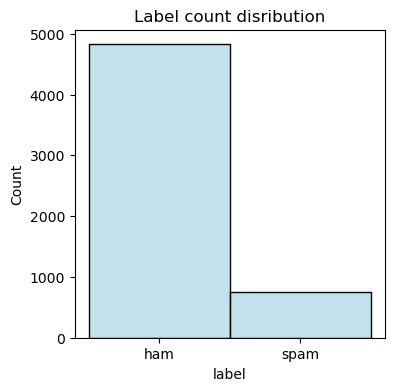

In [5]:
# Distribution
plt.figure(figsize=(4, 4))
sns.histplot(df, x = 'label', color = 'lightblue')
plt.title('Label count disribution')
plt.show()

In [6]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [7]:
# Print HAM message as an example
print('message: {}\n'.format(df.label[0]))
print(df.message[0])

message: ham

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


In [8]:
# Print SPAM message as an example
print('message: {}\n'.format(df.label[2]))
print(df.message[2])

message: spam

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


### Preprocess for Natural Language

In [9]:
# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fukudakodai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fukudakodai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Preprocess function
def preprocess_text(text):
    
    # Tokenize
    words = word_tokenize(text.lower())
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {}
    all_stopwords = stop_words.union(custom_stopwords)
    
    words = [word for word in words if word.isalnum() and word not in all_stopwords]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words)

In [11]:
# Apply preprocessing to the 'processed' column
df['processed']= df.message.apply(preprocess_text)
df.head()

,label,message,processed
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


In [12]:
# Print an example of the processed text
df['processed'][0]

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

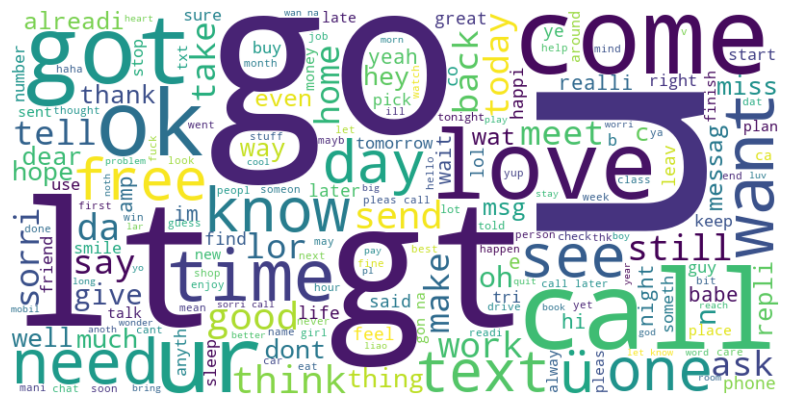

In [13]:
from wordcloud import WordCloud

text_all = ' '.join(df['processed'])

# Create WordCloud
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white').generate(text_all)

# Show WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
# Most common words
from collections import Counter

def extract_frequent_words(text, n_words):
    
    text = ' '.join(text)
    
    # Tokenize
    words = word_tokenize(text.lower())
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {}
    all_stopwords = stop_words.union(custom_stopwords)
    
    words = [word for word in words if word.isalnum() and word not in all_stopwords]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Count
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(n_words)
    
    # Print as Data Frame
    df = pd.DataFrame(most_common_words,
                      columns = ['Word', 'Frequency'])
    
    return df

extract_frequent_words(df.message, 10)

,Word,Frequency
0,u,1132
1,call,658
2,2,477
3,go,455
4,get,447
5,ur,391
6,gt,318
7,lt,316
8,come,303
9,4,288


### Split the data into train and test

In [15]:
X_train, X_test = train_test_split(df,
                                   test_size = 0.2,
                                   random_state = 0)

In [16]:
X_train.label.value_counts()

ham     3870
spam     587
Name: label, dtype: int64

## Vectorize Text data

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

X_vector = vectorizer.fit_transform(X_train['processed']).toarray()

## Non-negative Matrix Factorization

W: A document-topic matrix, where each row represents a document and each column represents a topic. The values in this matrix indicate the weights (or contributions) of each topic to a particular document.

H: A topic-term matrix, where each row reprents a topic and each column rpresents a word. The values in this matrix indicate the importance of each word for describing a particular topic.

In [18]:
n_category = 2  # the number of category

# NMF model
nmf_model = NMF(n_components = n_category, random_state = 0)
label_matrix = nmf_model.fit_transform(X_vector)

# Apply NMF
W = nmf_model.fit_transform(X_vector)
H = nmf_model.components_

In [19]:
W

array([[0.        , 0.10320795],
       [0.00542633, 0.00820399],
       [0.        , 0.09005211],
       ...,
       [0.00347269, 0.02027763],
       [0.01259482, 0.03222536],
       [0.00277606, 0.04151651]])

In [20]:
W.shape

(4457, 2)

In [21]:
# The importance of each word
components_df = pd.DataFrame(H,
                             columns = vectorizer.get_feature_names_out())
components_df

,008704050406,0089,0121,01223585236,01223585334,0125698789,02,0207,02073162414,021,...,zealand,zebra,zed,zero,zhong,zindgi,zoe,zouk,zyada,〨ud
0,0.000271,0.002253,0.002406,0.002098,0.001012,0.000000,0.000213,0.002428,0.000061,0.004155,...,0.000029,0.000159,0.000831,0.000000,0.000000,0.000000,0.000009,0.000019,0.000000,0.000000
1,0.000625,0.000214,0.000000,0.001038,0.000284,0.001389,0.000683,0.000000,0.000808,0.000802,...,0.000721,0.000532,0.002824,0.004501,0.002108,0.000074,0.001310,0.000090,0.000037,0.001582


In [22]:
H.shape

(2, 6058)

In [23]:
predicted_label = np.squeeze(np.asarray(W.argmax(axis=1)))
predicted_label

array([1, 1, 1, ..., 1, 1, 1])

In [24]:
label_to_category = {0: 'spam', 1: 'ham'}
predicted_category = np.vectorize(label_to_category.get)(predicted_label)
predicted_category

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [25]:
X_train['predicted_category'] = predicted_category
X_train

,label,message,processed,predicted_category
1114,ham,"No I'm good for the movie, is it ok if I leave...",good movi ok leav hourish,ham
3589,ham,If you were/are free i can give. Otherwise nal...,free give otherwis nalla adi entey nattil kittum,ham
3095,ham,Have you emigrated or something? Ok maybe 5.30...,emigr someth ok mayb bit hope,ham
1012,ham,"I just got home babe, are you still awake ?",got home babe still awak,ham
3320,ham,Kay... Since we are out already,kay sinc alreadi,ham
...,...,...,...,...
4931,spam,"Hi, the SEXYCHAT girls are waiting for you to ...",hi sexychat girl wait text text great night ch...,ham
3264,ham,So u gonna get deus ex?,u gon na get deu ex,ham
1653,spam,For ur chance to win a £250 cash every wk TXT:...,ur chanc win cash everi wk txt action c custca...,ham
2607,ham,R U &SAM P IN EACHOTHER. IF WE MEET WE CAN GO ...,r u sam p eachoth meet go 2 hous,ham


In [26]:
# Displaying the top words for each topic
feature_names = vectorizer.get_feature_names_out()
n_top_words = 20

for topic_idx, topic in enumerate(H):
    print(f"Topic #{topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic #0:
call later sorri meet free pleas prize claim mobil miss messag sir phone urgent custom wait da contact text min

Topic #1:
ok gt lt go come get lor home time ur good know want like got day need take send love



In [27]:
# Score
print(classification_report(X_train.label, X_train.predicted_category))

              precision    recall  f1-score   support

         ham       0.92      0.92      0.92      3870
        spam       0.46      0.47      0.46       587

    accuracy                           0.86      4457
   macro avg       0.69      0.69      0.69      4457
weighted avg       0.86      0.86      0.86      4457



Text(20.72222222222222, 0.5, 'True Labels')

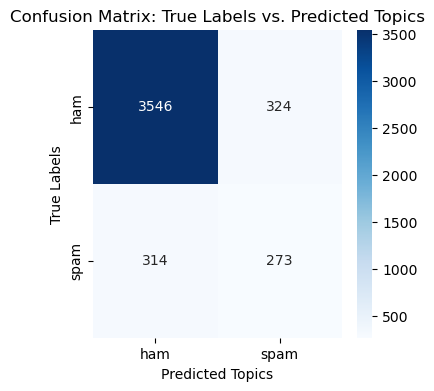

In [28]:
cm = confusion_matrix(X_train.label, X_train.predicted_category)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, 
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=X_train.label.unique(),
            yticklabels=X_train.label.unique())
plt.title('Confusion Matrix: True Labels vs. Predicted Topics')
plt.xlabel('Predicted Topics')
plt.ylabel('True Labels')

## Hyperparameter Tuning

In [29]:
def NMF_and_result(data, init, solver, beta_loss):
    nmf_model = NMF(n_components = n_category,
                    init = init, #['random', 'nndsvd']
                    solver = solver, #['cd', 'mu']
                    beta_loss = beta_loss, #['frobenius', 'kullback-leibler', 'itakura-saito']
                    random_state = 0)
    label_matrix = nmf_model.fit_transform(data)
    
    # Apply NMF
    W = nmf_model.fit_transform(data)
    H = nmf_model.components_
    
    # Get the label
    predicted_label = np.squeeze(np.asarray(W.argmax(axis=1)))
    
    predicted_category = np.vectorize(label_to_category.get)(predicted_label)
    
    return print(classification_report(X_train.label, predicted_category))

In [30]:
# init = 'nndsvd'
NMF_and_result(X_vector,
               init = 'nndsvd',
               solver = 'cd',
               beta_loss = 'frobenius')

              precision    recall  f1-score   support

         ham       0.92      0.91      0.92      3870
        spam       0.45      0.47      0.46       587

    accuracy                           0.85      4457
   macro avg       0.68      0.69      0.69      4457
weighted avg       0.86      0.85      0.86      4457



In [31]:
# solver = 'mu', beta_loss = 'kullback-leibler'
NMF_and_result(X_vector,
               init = 'random',
               solver = 'mu',
               beta_loss = 'kullback-leibler')

              precision    recall  f1-score   support

         ham       0.75      0.38      0.50      3870
        spam       0.04      0.18      0.07       587

    accuracy                           0.35      4457
   macro avg       0.40      0.28      0.29      4457
weighted avg       0.66      0.35      0.45      4457



In [32]:
# init = 'nndsvd', solver = 'mu', beta_loss = 'kullback-leibler'
NMF_and_result(X_vector,
               init = 'nndsvd',
               solver = 'mu',
               beta_loss = 'kullback-leibler')

/Users/fukudakodai/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/Users/fukudakodai/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


              precision    recall  f1-score   support

         ham       0.99      0.66      0.79      3870
        spam       0.30      0.97      0.46       587

    accuracy                           0.70      4457
   macro avg       0.65      0.81      0.62      4457
weighted avg       0.90      0.70      0.75      4457



### Which hyperparameters should we use?
When distinguishing between spam and ham, it’s important to consider the following metrics:

- **Precision** : This indicates the proportion of emails classified as spam that are actually spam. High precision means a low risk of misclassifying ham as spam.<br><br>

- **Recall** : This measures the proportion of actual spam emails that were correctly identified as spam. High recall indicates a low risk of missing spam emails.<br><br>

- **Accuracy** : This shows the overall correctness of the classification. However, in cases of imbalanced datasets with more ham than spam, accuracy alone may not provide a complete picture.<br><br>

### Choosing Metrics Based on Context
- **If the risk of incorrectly classifying ham as spam is significant** (for example, missing important emails), prioritize Precision.<br><br>

- **If the risk of missing spam is more concerning** (such as in environments overwhelmed by junk mail), prioritize Recall.<br><br>
In this project, I prioritize Recall as the risk of missing spam is more significant. So, the best parameter I choose is below;

`init = 'nndsvd', solver = 'mu', beta_loss = 'kullback-leibler'`

In [33]:
# Best NMF model
best_nmf = NMF(n_components = n_category,
               init = 'nndsvd',
               solver = 'mu',
               beta_loss = 'kullback-leibler',
               random_state = 0)

## Test data

In [34]:
test_pred_categ = np.vectorize(label_to_category.get)(
    best_nmf.fit_transform(vectorizer.transform(
        X_test["processed"].apply(preprocess_text))).argmax(axis=1))

print(classification_report(X_test.label, test_pred_categ))

              precision    recall  f1-score   support

         ham       0.99      0.65      0.78       955
        spam       0.31      0.95      0.47       160

    accuracy                           0.69      1115
   macro avg       0.65      0.80      0.63      1115
weighted avg       0.89      0.69      0.74      1115



/Users/fukudakodai/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


## Does Under-sampling improve the model performances?

In this dataset there are 4825 HAMs and 747 SPAMs. This data imbalance can significantly impact SPAM detection in several ways.
For example, the model tends to favor the majority class. This bias can lead to a higher rate of False Negatives, where SPAM emails are incorrectly classified as HAM. Also, a model trained on imbalanced data might overfit the minority class (SPAM) or majority class (HAM), leading to poor generalization on new, unseen data.

This time, I carried out Under-sampling method. Under-sampling addresses the issues mentioned above by reducing randomly the number of instances in the majority class, leading to the creation of a more balanced dataset.

As shown below, however, the balanced data did not contribute to improving the model performances; the f1-score in SPAM increased, which means that the balance between Recall and Precision was improved. On the other hand, conversely, the ability to detect HAMs has decreased. Accuracy score also decreased.

This is mainly due to the loss of potentially valuable information that could help the model learn better patterns. This can lead to underfitting, where the model fails to capture the complexities of the data.

In [35]:
# Under-sampling function
def balance_classes(data):
    
    #Check the number of samples in each class
    class_counts = data['label'].value_counts()
    min_class_size = class_counts.min()
    
    # Perform under-sampling
    balanced_data = data.groupby('label').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)
    
    return balanced_data

# Get balanced data
balanced_X = balance_classes(X_train)

balanced_X.groupby('label').count()

,message,processed,predicted_category
label,,,
ham,587,587,587
spam,587,587,587


In [36]:
X_vec = vectorizer.fit_transform(balanced_X['processed']).toarray()

# NMF model
label_matrix = best_nmf.fit_transform(X_vec)

# Apply NMF
W = best_nmf.fit_transform(X_vec)
H = best_nmf.components_

/Users/fukudakodai/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/Users/fukudakodai/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


In [37]:
predicted_label_balanced = np.squeeze(np.asarray(W.argmax(axis=1)))
predicted_category_balanced = np.vectorize(label_to_category.get)(predicted_label_balanced)

# Score
print(classification_report(balanced_X.label, predicted_category_balanced))

              precision    recall  f1-score   support

         ham       0.61      0.64      0.63       587
        spam       0.62      0.59      0.61       587

    accuracy                           0.62      1174
   macro avg       0.62      0.62      0.62      1174
weighted avg       0.62      0.62      0.62      1174



## Comparison with Supervised Learning Models

In [38]:
# Data cleaning
X = df.processed
y = df.label.factorize()[0]

# Split the data
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y,
                                                                test_size = 0.2,
                                                                random_state = 0)
# Vectorizer
X_train_sm = vectorizer.fit_transform(X_train_sm).toarray()
X_test_sm = vectorizer.fit_transform(X_test_sm).toarray()

<Axes: xlabel='model_name', ylabel='recall'>

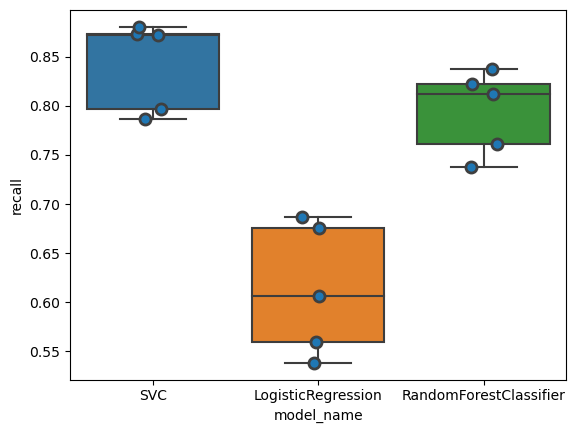

In [39]:
# Cross Validation
from sklearn.model_selection import cross_val_score

labels = y_train_sm

models = [SVC(kernel='linear', gamma=5),
          LogisticRegression(random_state=0),
          RandomForestClassifier()]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X_train_sm, labels, scoring='recall', cv=CV)
    
    for fold_idx, recall in enumerate(scores):
        entries.append([model_name, fold_idx, recall])

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'recall'])

# Visualization
sns.boxplot(x='model_name', y='recall', data=cv_df)
sns.stripplot(x='model_name', y='recall', data=cv_df, size=8, jitter=True, linewidth=2)

<Axes: xlabel='model_name', ylabel='accuracy'>

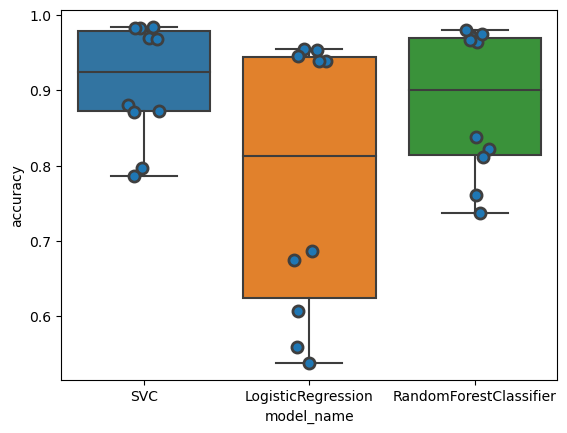

In [40]:
# Accuracy
for model in models:
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X_train_sm, labels, scoring='accuracy', cv=CV)
    
    for fold_idx, accuracy in enumerate(scores):
        entries.append([model_name, fold_idx, accuracy])

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# Visualization
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, linewidth=2)

## Comparison with K-means

In [41]:
from sklearn.cluster import KMeans

# Model
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_vector)

# Predict
predicted_clusters = kmeans.labels_

# Convert labels
kmeans_labels = np.where(predicted_clusters == 0, 'ham', 'spam')

              precision    recall  f1-score   support

         ham       0.87      0.95      0.91      3870
        spam       0.19      0.07      0.10       587

    accuracy                           0.84      4457
   macro avg       0.53      0.51      0.51      4457
weighted avg       0.78      0.84      0.80      4457



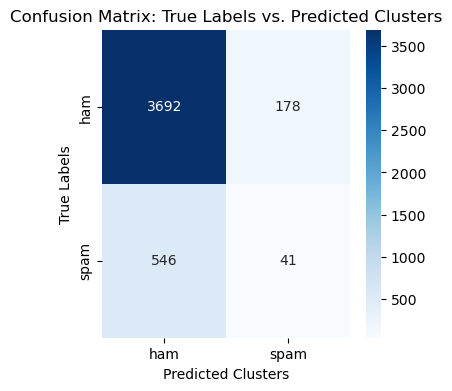

In [42]:
# Score
print(classification_report(X_train.label, kmeans_labels))

# Confusion Matrix
cm = confusion_matrix(X_train.label, kmeans_labels)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=X_train.label.unique(), yticklabels=X_train.label.unique())
plt.title('Confusion Matrix: True Labels vs. Predicted Clusters')
plt.xlabel('Predicted Clusters')
plt.ylabel('True Labels')
plt.show()

## Conclusions

On the dataset in this study, Support Vector Machine method detected SPAM with overall high accuracy. The approach using unsupervised learning Non-negative Matrix Factorisation did not perform well in distinguishing between HAM and SPAM.

There seem to be several reasons why Non-negative Matrix Factorization (NMF) may not perform well in spam detection.
- NMF is primarily a feature extraction or dimensionality reduction technique, not a classifier. To effectively distinguish between spam and ham, the output of NMF needs to be passed to another classification algorithm.<br><br>

- While NMF aims to discover latent topics, the extracted features may not clearly differentiate between SPAM and HAM. If the identified topics are not specific to SPAM, their effectiveness diminishes.<br><br>

- The dataset is imbalanced. With significantly fewer SPAM examples, NMF may have difficulty learning the important features necessary for effective detection. Under-sampling did not work at all because sufficient information was lost to build an effective model for detecting SPAM.<br>

K-means clustering also struggled with SPAM detection. This method is an unsupervised learning techniques, so without accurate label information, it may become challenging for the model to effectively separate SPAM from HAM. Supervised learning methods like SVM yield better results in distinguishing between SPAM and HAM.